#  <strong>Import Library

In [1]:
import tensorflow as tf
import logging
from sklearn.metrics import classification_report

tf.get_logger().setLevel(logging.ERROR) # IGNORE WARNING


In [2]:
# LIMIT GPU ALLOCATION
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  

In [3]:
# TO COLLECT GARBAGE AND FREE MEMORY

import gc
gc.collect()

0

# <strong>Load Dataset

In [4]:
# GET A DIRECTORY

import os

BASE_DIR = r'Animals'

TRAIN_DIR = os.path.join(BASE_DIR,'train')
TEST_DIR = os.path.join(BASE_DIR,'test')



lets see image size of dataset

In [5]:
# THIS CELL IS TO SEE HOW MUCH SIZE OF THE IMAGE
# U CAN RUN THIS CELL 

from PIL import Image
import os

# ACCESSED IMAGE PATH
directory = r'.\Animals\train\snakes'  

# TO SEE SIZE OF IMAGE
for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # FIND JPG / PNG FILE

        # GET IMAGE PATH LOCATED
        img_path = os.path.join(directory, filename)       

        # OPEN IMAGE FILE
        with Image.open(img_path) as img:
            print(f'Image Size : {filename}: {img.size}') 
            break                            # JUST WANNA SEE SIZE OF 1 IMAGE

Image Size : 2_0001.jpg: (256, 256)


# <strong> Pre-Processing Data

In [6]:

# LOAD TRAIN DATASET AND CONVERT IT TO TENSOR DATASET
TRAIN_DATASET = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',          # INFERRED MEAN , TAKE THE FOLDER NAME AS A LABEL
    label_mode='categorical',   # THERE IS MULTI LABEL IN DATASET (3 LABEL)
    batch_size=16,
    image_size=(224,224),       # RESIZE ALL IMAGE TO 215x215
    color_mode='rgb',           # SET COLOR TO RGB
    shuffle=True,               
    seed=12
)

# LOAD TEST DATASET AND CONVERT IT TO TENSOR DATASET
TEST_DATASET = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    labels='inferred',         # TAKE THE FOLDER NAME AS A LABEL
    label_mode='categorical',  # THERE IS MULTI LABEL IN DATASET (cats, dog, snake)
    batch_size=16,
    image_size=(224,224),      # RE-SIZE IMAGE TO 215x215
    color_mode='rgb',
    shuffle=True,
    seed=12
)

Found 2400 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


cells below used to speed up the training proccess

In [7]:
#USING PREFETCH TO FASTER TRAINING

TRAIN_DATASET = TRAIN_DATASET.prefetch(buffer_size =tf.data.AUTOTUNE).cache().shuffle(2400)
TEST_DATASET = TEST_DATASET.prefetch(buffer_size= tf.data.AUTOTUNE).cache().shuffle(600)

''' 
NOTE : tf.data.AUTOTUNE used to select the best buffer size based on Available Resources
'''

' \nNOTE : tf.data.AUTOTUNE used to select the best buffer size based on Available Resources\n'

ok lets visualize some images

['cats', 'dogs', 'snakes']


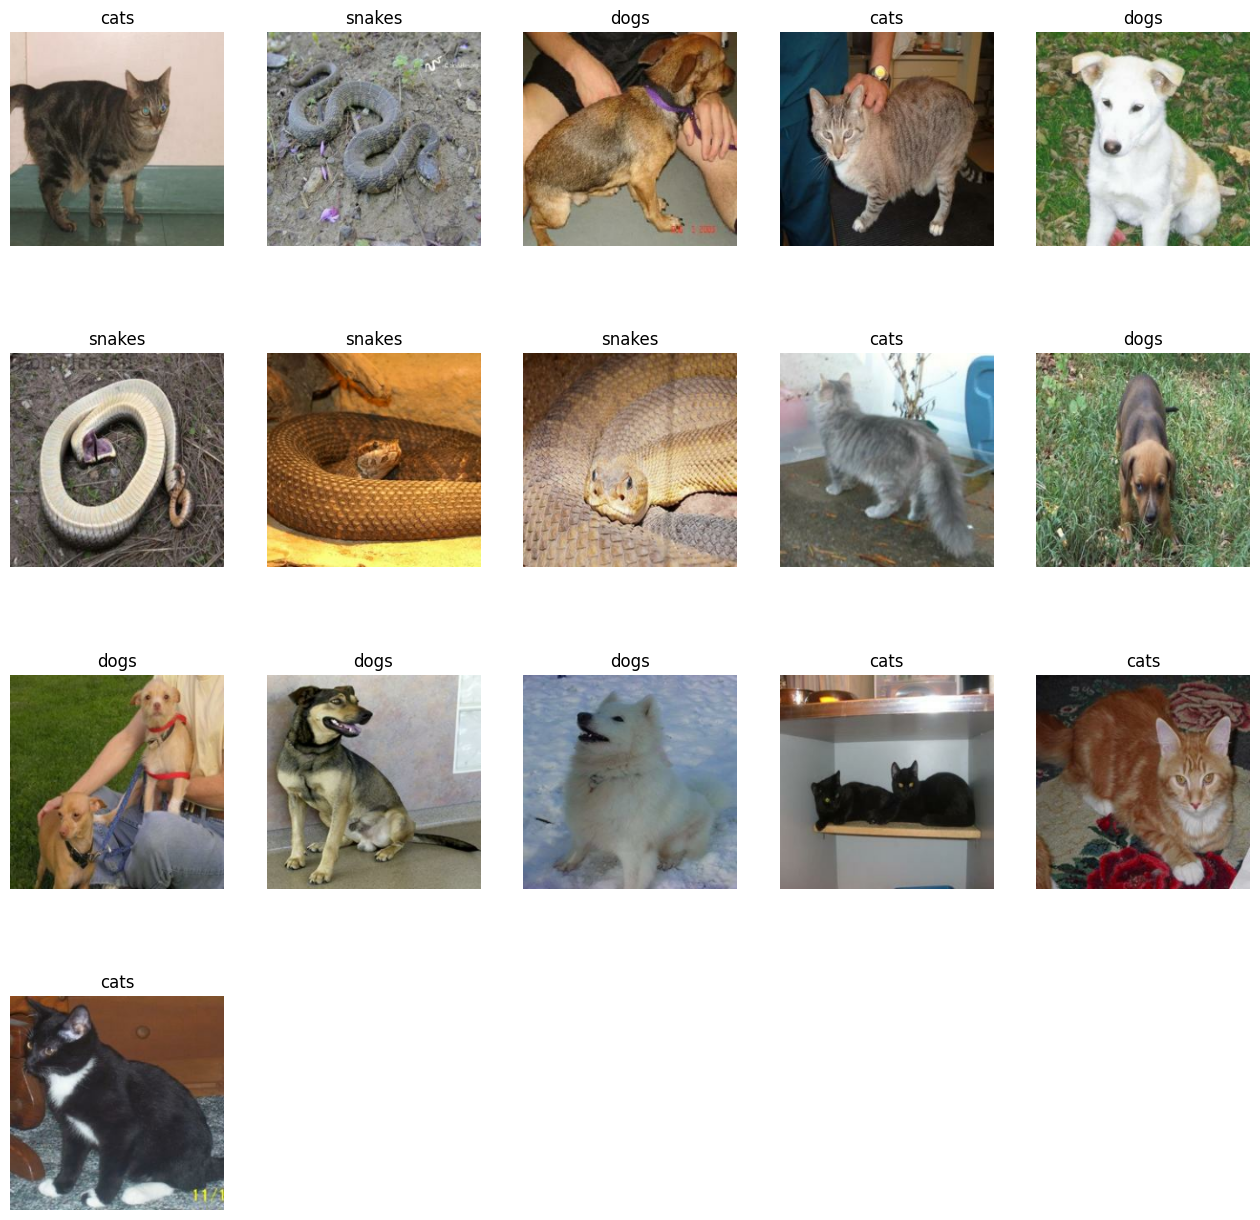

In [8]:
# SHOW AN IMAGE
import matplotlib.pyplot as plt
import numpy as np 

class_names = os.listdir(TRAIN_DIR) # TAKE NAME ALL FOLDER
print(class_names) # CHECK LABEL OF CLASS   

for image , label in TRAIN_DATASET.take(1): # TAKE 1 BATCH IMAGE (SHUFFLED)

    plt.figure(figsize=(16,16))

    for i in range(16): # DISPLAY 20 IMAGE (BASED ON 1 BATCH)
        plt.subplot(4,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8')) # MENAMPILKAN GAMBAR DGN MENGUBAH TENSOR image[i] ke array numpy dan dgn rentang uint8 

        animal = tf.argmax(input=label[i])  # TAKE HIGHEST VALUE IN ARRAY . EXAMP = [0 0 1] = 2
        plt.title(class_names[animal]) # IF HIGHEST VALUE = 2 , THEN class_names[2] 
        plt.axis('off')

In [9]:
# DISPLAY DIMENSION IMAGE OF DATA TRAINING
for image , label in TRAIN_DATASET.take(1):
    print(image.shape)
    print(label.shape)

# DISPLAY DIMENSION IMAGE OF DATA TESTING
for image , label in TEST_DATASET.take(1):
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16, 3)
(16, 224, 224, 3)
(16, 3)


data augmentation

In [10]:
# DATA AUGMENTATION

image_augmentation = tf.keras.Sequential(
    layers=[
        # FLIP AN IMAGE BY HORIZONTAL
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal',seed=12),

        # IT CAN ROTATED AN IMAGE MAX 20% OF 360
        tf.keras.layers.experimental.preprocessing.CenterCrop(height=int(256 * 0.90),width=int(256 * 0.92)),

        #tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor=0.2,fill_mode='nearest',seed=12),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2,width_factor=0.3,fill_mode='nearest',seed=12)
    ]
)

image_augmentation

# <strong>Create CNN Architecture

In [11]:
# CREATE CNN ARCHITECTURE WITH 3 CONV LAYERS AND 2 DENSE LAYERS

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Rescaling(scale=1./255),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(units=3,activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)     

In [12]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [13]:
# COMPILE

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
# STOP THE TRAINING IF VALIDATION ACCURACY MORE THAN 0.85 OR ACCURACY MORE THAN OR EQUAL 0.99

class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs['val_accuracy'] > 0.85 or logs['accuracy'] >= 0.99:
            self.model.stop_training = True
            

# <strong>Train Model

In [15]:

history = model.fit(x= TRAIN_DATASET ,batch_size=32, epochs=20, callbacks=[mycallback()],validation_data=TEST_DATASET)

Epoch 1/20
150/150 [==============================] - 10s 56ms/step - loss: 5.1155 - accuracy: 0.5492 - val_loss: 1.1064 - val_accuracy: 0.3417
Epoch 2/20
150/150 [==============================] - 7s 45ms/step - loss: 0.8202 - accuracy: 0.6058 - val_loss: 1.2954 - val_accuracy: 0.3567
Epoch 3/20
150/150 [==============================] - 7s 49ms/step - loss: 0.7519 - accuracy: 0.6283 - val_loss: 1.1642 - val_accuracy: 0.4883
Epoch 4/20
150/150 [==============================] - 7s 50ms/step - loss: 0.6935 - accuracy: 0.6658 - val_loss: 0.8588 - val_accuracy: 0.6433
Epoch 5/20
150/150 [==============================] - 8s 51ms/step - loss: 0.6236 - accuracy: 0.6946 - val_loss: 0.8576 - val_accuracy: 0.6417
Epoch 6/20
150/150 [==============================] - 7s 50ms/step - loss: 0.5621 - accuracy: 0.7242 - val_loss: 1.2370 - val_accuracy: 0.5800
Epoch 7/20
150/150 [==============================] - 7s 50ms/step - loss: 0.5636 - accuracy: 0.7392 - val_loss: 1.0269 - val_accuracy: 0.571

# <strong>Evaluation

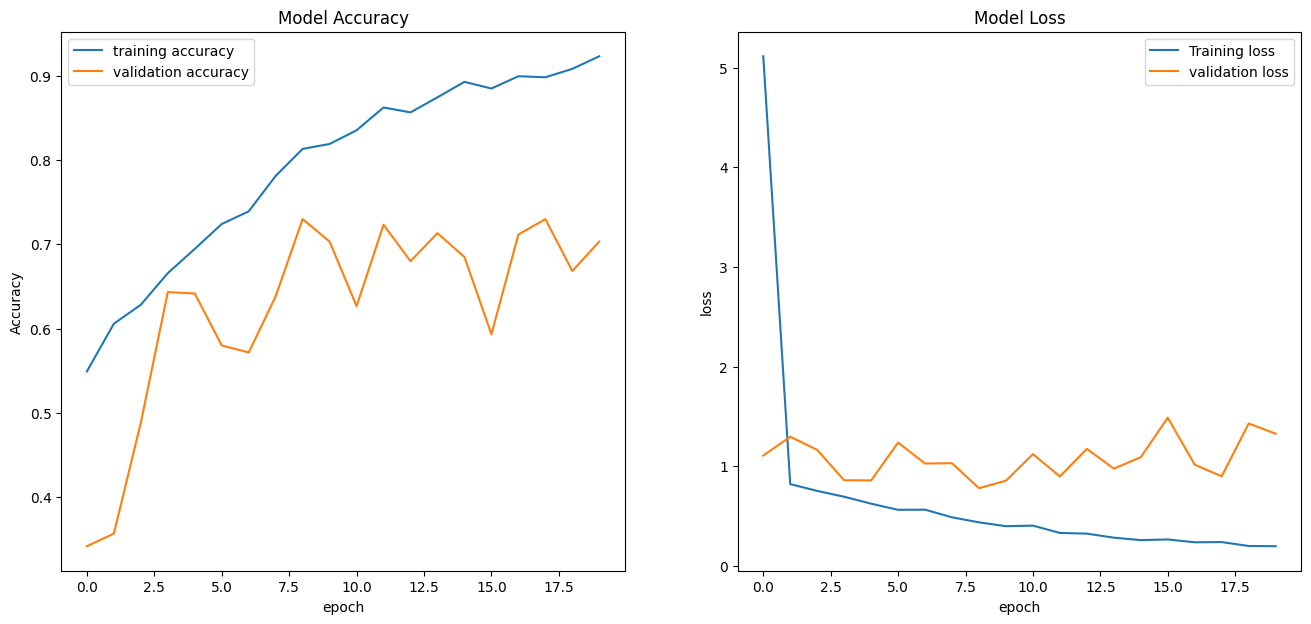

In [16]:
# VISUALIZE MODEL PERFORMANCE

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epoch = range(len(loss))

fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(16,7))

axes[0].plot(epoch, accuracy, label='training accuracy')
axes[0].plot(epoch,val_accuracy, label='validation accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epoch, loss, label='Training loss')
axes[1].plot(epoch, val_loss, label='validation loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [17]:
# SHOW LOSS AND ACCURACY METRICS

loss , accuracy = model.evaluate(TEST_DATASET)

loss , accuracy

38/38 [==============================] - 0s 10ms/step - loss: 1.3264 - accuracy: 0.7033


(1.326385736465454, 0.70333331823349)

ok lets create confusion Matrix

In [18]:
y_true = []
y_pred = []

for images , labels in TEST_DATASET:

    y_hat = np.argmax(model.predict(images, verbose=0), axis=1)  # PREDICT A MODEL AND FIND HIGHEST PROBABILITIES IN EVERY SAMPLE
    
    y_pred.extend(y_hat) 
    y_true.extend(np.argmax(labels, axis=1))

# SHOW CONFUSION MATRIX
print('Confusion Matrix : ')
print(classification_report(y_true, y_pred))

Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.71      0.53      0.61       200
           1       0.63      0.66      0.65       200
           2       0.76      0.93      0.83       200

    accuracy                           0.70       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.70      0.70      0.69       600



confusion matrix with data augmentation

Confusion Matrix : 
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       200
           1       0.64      0.54      0.58       200
           2       0.73      0.93      0.81       200

    accuracy                           0.68       600
   macro avg       0.67      0.68      0.67       600 <br>
weighted avg       0.67      0.68      0.67       600

1/1 [==============================] - 0s 23ms/step


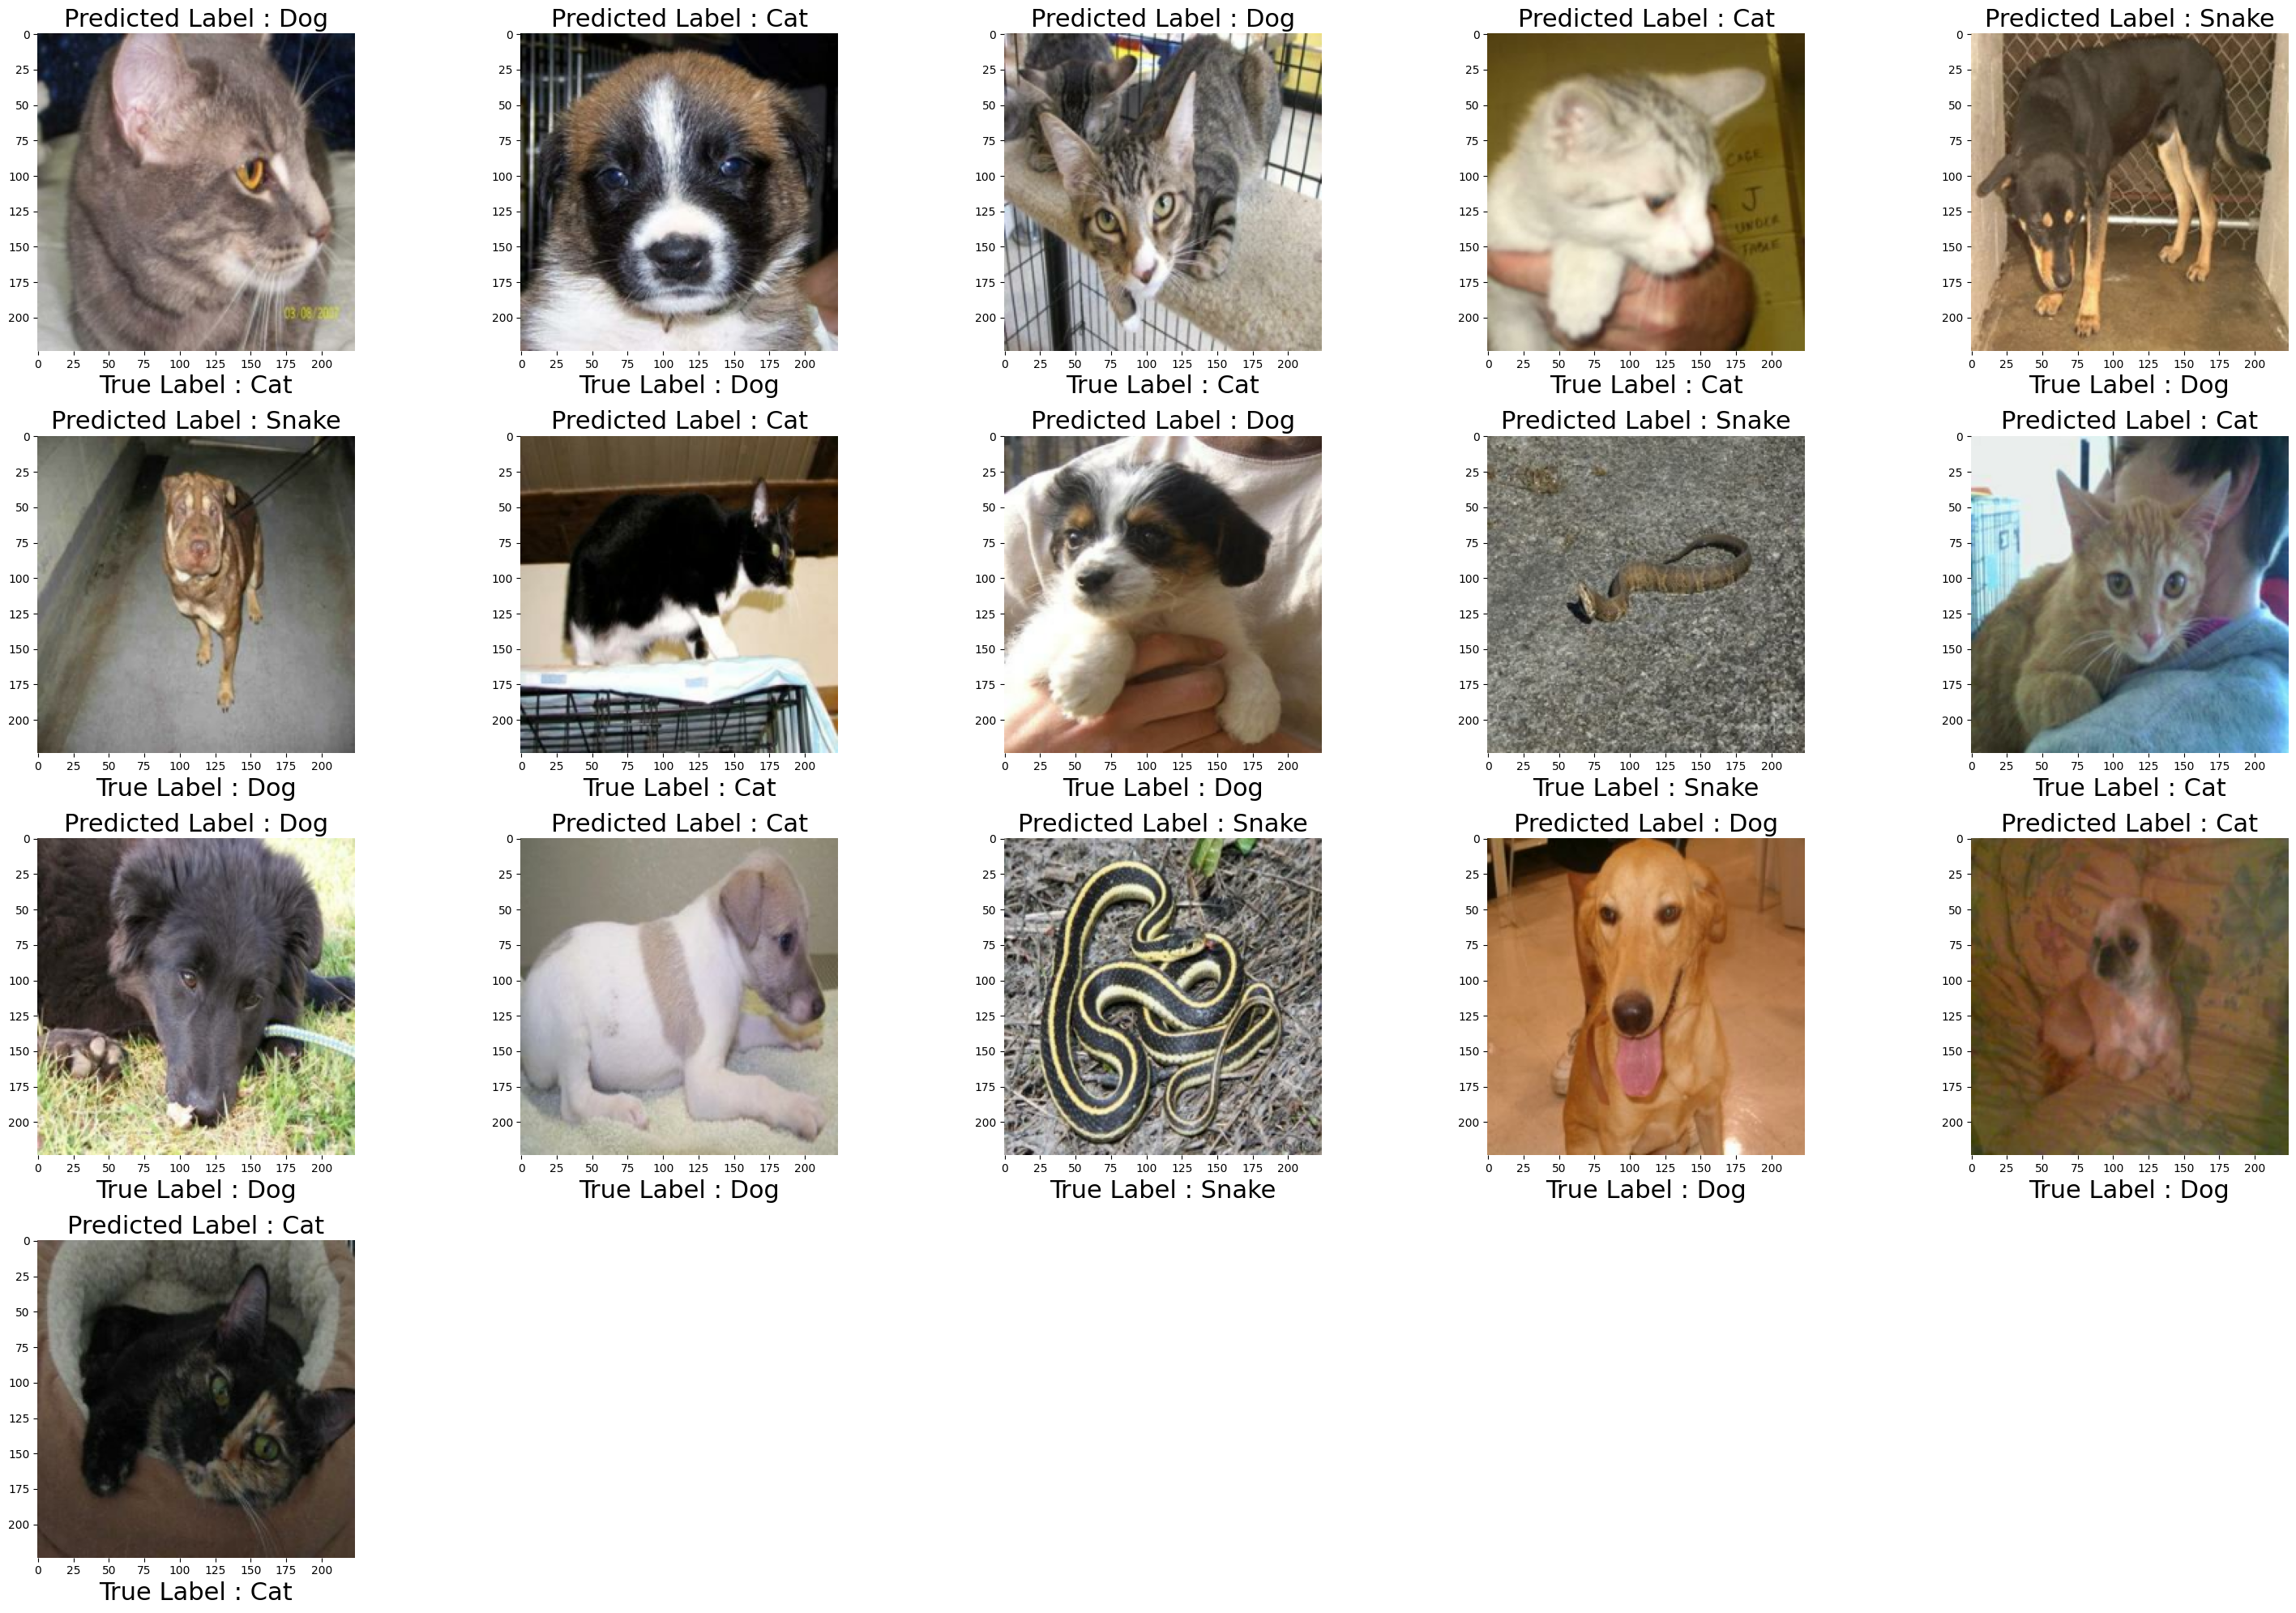

In [ ]:
# SHOW PREDICTED IMAGE IN 1 BATCH

plt.figure(figsize=(30,20))

animal = {
    0 : 'Cat',
    1 : 'Dog',
    2 : 'Snake'
}

# TAKE 1 BATCH DATASET (1 BATCH = 16 IMAGES)
for images, labels in TEST_DATASET.take(1):

    # PREDICT AN IMAGE 
    y_hat = np.argmax( model.predict(images), axis=1) 

    # ITERATE ALL SAMPLES ON 1 BATCH
    for i in range(images.shape[0]):  # images.shape = (16, 215, 215, 3)
        plt.subplot(4, 5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))  # .astype() IS USED TO RETURN AN IMAGE TO THE RANGE 0 TO 255

        # MATCH THE LABEL WITH ANIMAL NAMES
        predicted_label = animal[y_hat[i]]
        true_label      = animal[ np.argmax(labels[i]) ]

        plt.title(f'Predicted Label : {predicted_label}', fontsize=22)   # SHOW PREDICTED LABEL
        plt.xlabel(f'True Label : {true_label}', fontsize=22)            # SHOW TRUE LABEL
        plt.box(False)

plt.tight_layout()
plt.show()